### Boilerplate Code  

In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from pip import main
main(["install","lightgbm","tqdm"])

You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


0

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [11]:
## inspecting missing values
def inspect_missing(df):
    total = df.isnull().sum().sort_values(ascending=True)
    percent = (df.isnull().sum()/len(df)*100).sort_values(ascending=True)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

#### Train Data Import

In [12]:
import pandas as pd
train_data = pd.read_csv('train.csv')
train_data.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [13]:
train_data = reduce_mem_usage(train_data)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


#### Importing the building weather data

In [14]:
weather_train = reduce_mem_usage(pd.read_csv('weather_train.csv'))
weather_train.head()

Mem. usage decreased to  3.07 Mb (68.1% reduction)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


#### Loading building metadata

In [99]:
building_metadata = reduce_mem_usage(pd.read_csv('building_metadata.csv'))
building_metadata.head()

Mem. usage decreased to  0.03 Mb (60.3% reduction)


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


### EDA

In [16]:
# 0: electricity, 1: chilledwater, 2: steam, hotwater: 3
meters = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
train_data['meter_type'] = train_data['meter'].map(meters)

In [17]:
from collections import Counter
Counter(train_data['meter_type']).most_common(4)

[('electricity', 12060910),
 ('chilledwater', 4182440),
 ('steam', 2708713),
 ('hotwater', 1264037)]

#### Inspect Missing Values

In [18]:
inspect_missing(train_data)

,Total,Percent
building_id,0,0.0
meter,0,0.0
timestamp,0,0.0
meter_reading,0,0.0
meter_type,0,0.0


In [19]:
inspect_missing(weather_train)

,Total,Percent
site_id,0,0.000000
timestamp,0,0.000000
air_temperature,55,0.039350
dew_temperature,113,0.080845
wind_speed,304,0.217496
wind_direction,6268,4.484414
sea_level_pressure,10618,7.596603
precip_depth_1_hr,50289,35.979052
cloud_coverage,69173,49.489529


In [20]:
inspect_missing(building_metadata)

,Total,Percent
site_id,0,0.000000
building_id,0,0.000000
primary_use,0,0.000000
square_feet,0,0.000000
year_built,774,53.416149
floor_count,1094,75.500345


#### Correlations

In [21]:
train_data.corr()['meter_reading'].sort_values(ascending=False)[1:]

meter          0.017672
building_id    0.008761
Name: meter_reading, dtype: float64

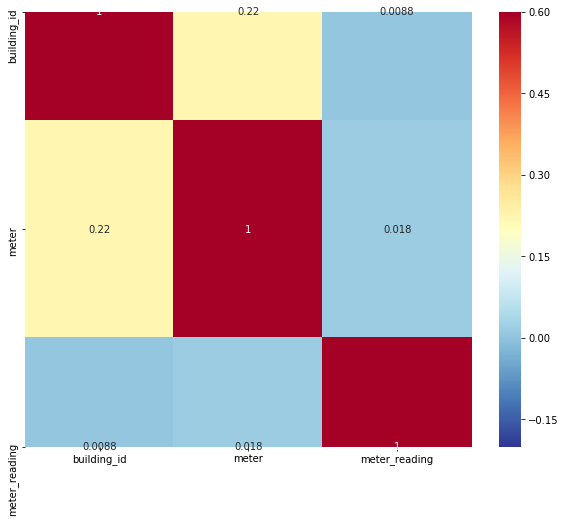

In [22]:
## plotting correlations
plt.figure(figsize = (10, 8))
sns.heatmap(train_data.corr(), cmap=plt.cm.RdYlBu_r, vmin=-0.2, vmax=0.6, annot=True)

#### Distribution plots

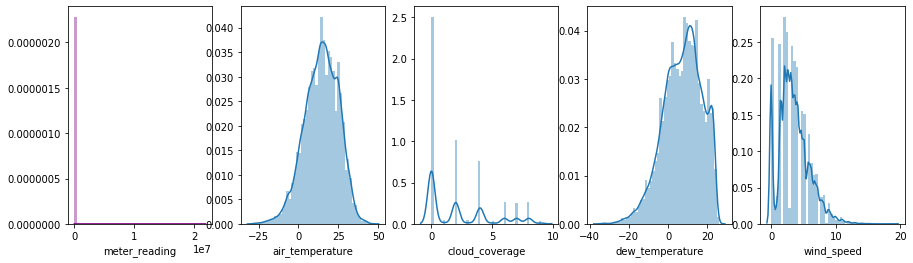

In [23]:
plt.figure(figsize= (15,4))
plt.subplot(1,5,1)
sns.distplot(train_data['meter_reading'].dropna(), color='purple')
plt.subplot(1,5,2)
sns.distplot(weather_train['air_temperature'].dropna())
plt.subplot(1,5,3)
sns.distplot(weather_train['cloud_coverage'].dropna())
plt.subplot(1,5,4)
sns.distplot(weather_train['dew_temperature'].dropna())
plt.subplot(1,5,5)
sns.distplot(weather_train['wind_speed'].dropna())

#### Time Series 

In [24]:
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])

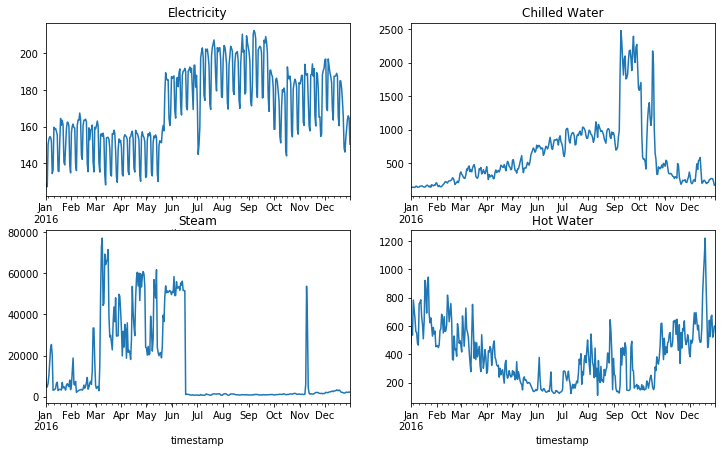

In [25]:
plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
train_data[train_data['meter_type']=='electricity'].set_index('timestamp')['meter_reading'].resample('D').mean().plot(title='Electricity')
plt.subplot(2,2,2)
train_data[train_data['meter_type']=='chilledwater'].set_index('timestamp')['meter_reading'].resample('D').mean().plot(title='Chilled Water')
plt.subplot(2,2,3)
train_data[train_data['meter_type']=='steam'].set_index('timestamp')['meter_reading'].resample('D').mean().plot(title='Steam')
plt.subplot(2,2,4)
train_data[train_data['meter_type']=='hotwater'].set_index('timestamp')['meter_reading'].resample('D').mean().plot(title='Hot Water')

#### Detecting Outliers

In [26]:
### steam data raises some eyebrows

In [27]:
train_data.head()

,building_id,meter,timestamp,meter_reading,meter_type
0,0,0,2016-01-01,0.0,electricity
1,1,0,2016-01-01,0.0,electricity
2,2,0,2016-01-01,0.0,electricity
3,3,0,2016-01-01,0.0,electricity
4,4,0,2016-01-01,0.0,electricity


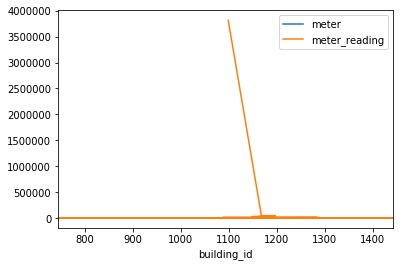

In [28]:
train_data[train_data.meter_type=='steam'].groupby('building_id').mean().sort_values('meter_reading', ascending=False).plot()

timestamp
2016-01-31    AxesSubplot(0.125,0.125;0.775x0.755)
2016-02-29    AxesSubplot(0.125,0.125;0.775x0.755)
2016-03-31    AxesSubplot(0.125,0.125;0.775x0.755)
2016-04-30    AxesSubplot(0.125,0.125;0.775x0.755)
2016-05-31    AxesSubplot(0.125,0.125;0.775x0.755)
2016-06-30    AxesSubplot(0.125,0.125;0.775x0.755)
2016-07-31    AxesSubplot(0.125,0.125;0.775x0.755)
2016-08-31    AxesSubplot(0.125,0.125;0.775x0.755)
2016-09-30    AxesSubplot(0.125,0.125;0.775x0.755)
2016-10-31    AxesSubplot(0.125,0.125;0.775x0.755)
2016-11-30    AxesSubplot(0.125,0.125;0.775x0.755)
2016-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

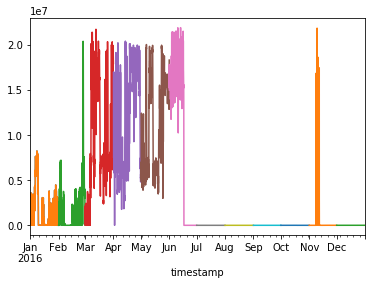

In [29]:
train_data[(train_data.building_id==1099)&(train_data.meter_type=='steam')].set_index('timestamp')['meter_reading'].resample('M').plot()

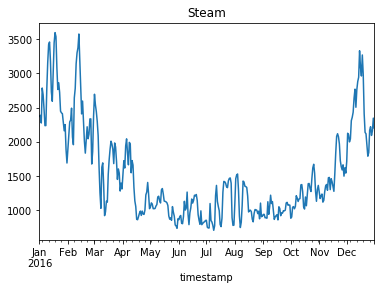

In [30]:
train_data[(train_data['meter_type']=='steam')&(train_data.building_id!=1099)].set_index('timestamp')['meter_reading'].resample('D').mean().plot(title='Steam')

#### Mergin train and meta data

In [31]:
train_meta = train_data.merge(building_metadata, on='building_id')
train_meta.head()

,building_id,meter,timestamp,meter_reading,meter_type,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,electricity,0,Education,7432,2008.0,NaN
1,0,0,2016-01-01 01:00:00,0.0,electricity,0,Education,7432,2008.0,NaN
2,0,0,2016-01-01 02:00:00,0.0,electricity,0,Education,7432,2008.0,NaN
3,0,0,2016-01-01 03:00:00,0.0,electricity,0,Education,7432,2008.0,NaN
4,0,0,2016-01-01 04:00:00,0.0,electricity,0,Education,7432,2008.0,NaN


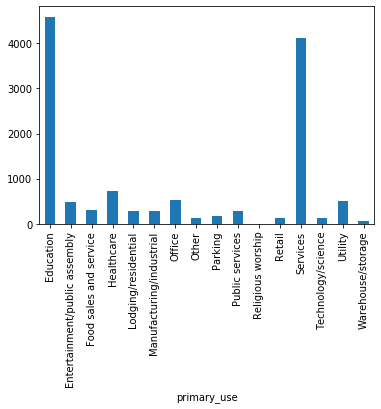

In [32]:
train_meta.groupby('primary_use')['meter_reading'].mean().plot(kind='bar')

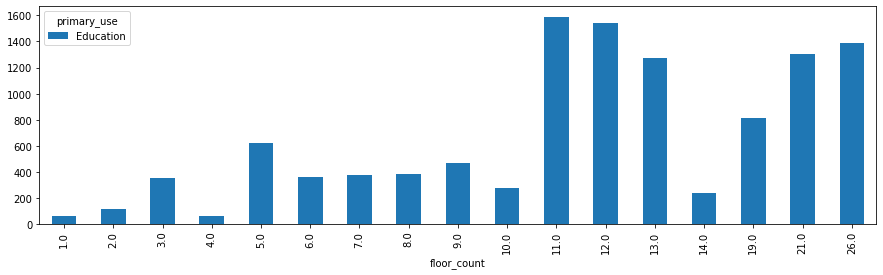

In [33]:
train_meta[train_meta['primary_use'].isin(['Education','Services'])].groupby(['floor_count','primary_use'])['meter_reading'].mean().unstack().plot(kind='bar',figsize=(15,4))
# floor count for services is missing

#### EDA site id wise

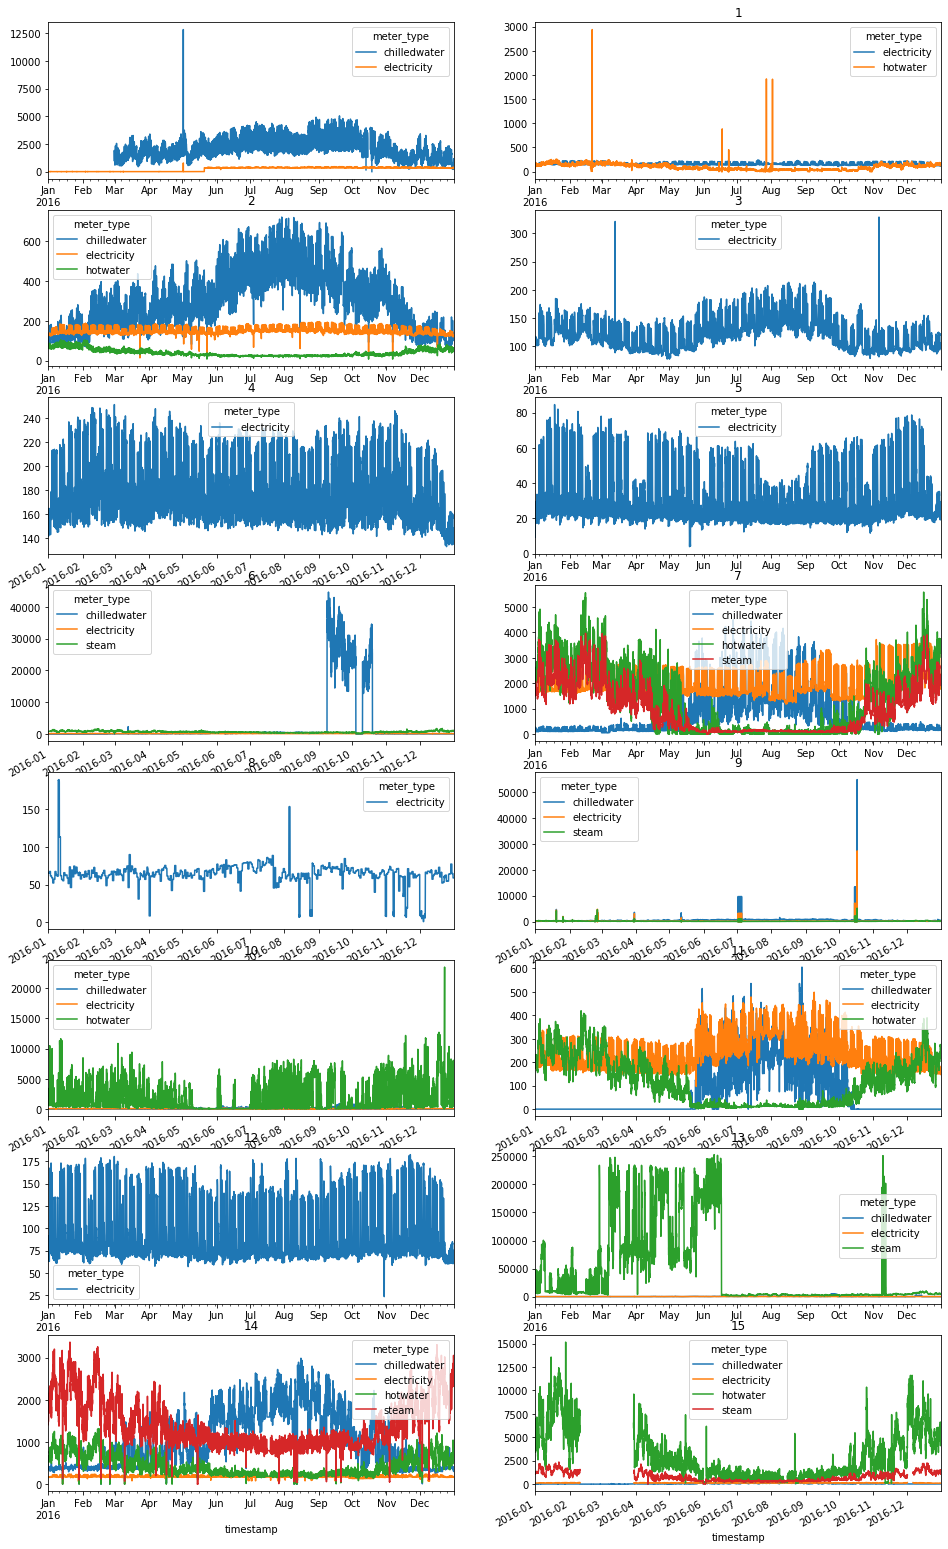

In [34]:
plt.figure(figsize=(16,30))
for site_id in range(0,16):
    plt.subplot(8,2,site_id+1)    
    train_meta[train_meta['site_id']==site_id].groupby(['timestamp','meter_type']).mean()['meter_reading'].unstack().plot(title=site_id, ax=plt.gca())


 Site 0 has missing data for first few months. Also there is data missing at site 15 for some meters. 

In [35]:
#remove all rows of site 0 where meter reading is missing 
train_meta = train_meta.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

### Feature Creation

In [36]:
## Extrapolating from datetime
def datetime_features(df):
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

In [37]:
datetime_features(train_meta)
train_meta.head()

,building_id,meter,timestamp,meter_reading,meter_type,site_id,primary_use,square_feet,year_built,floor_count,hour,weekend,month,dayofweek
3361,0,0,2016-05-20 01:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,1,4,5,4
3362,0,0,2016-05-20 02:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,2,4,5,4
3363,0,0,2016-05-20 03:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,3,4,5,4
3364,0,0,2016-05-20 04:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,4,4,5,4
3365,0,0,2016-05-20 05:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,5,4,5,4


In [38]:
train_meta['meter_reading_log1p'] = np.log1p(train_meta['meter_reading'])

In [39]:
df_group = train_meta.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_meta['building_mean'] = train_meta['building_id'].map(building_mean)
train_meta['building_median'] = train_meta['building_id'].map(building_median)
train_meta['building_min'] = train_meta['building_id'].map(building_min)
train_meta['building_max'] = train_meta['building_id'].map(building_max)
train_meta['building_std'] = train_meta['building_id'].map(building_std)

train_meta.head()

,building_id,meter,timestamp,meter_reading,meter_type,site_id,primary_use,square_feet,year_built,floor_count,hour,weekend,month,dayofweek,meter_reading_log1p,building_mean,building_median,building_min,building_max,building_std
3361,0,0,2016-05-20 01:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,1,4,5,4,0.0,5.433594,5.488281,0.0,5.804688,0.392578
3362,0,0,2016-05-20 02:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,2,4,5,4,0.0,5.433594,5.488281,0.0,5.804688,0.392578
3363,0,0,2016-05-20 03:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,3,4,5,4,0.0,5.433594,5.488281,0.0,5.804688,0.392578
3364,0,0,2016-05-20 04:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,4,4,5,4,0.0,5.433594,5.488281,0.0,5.804688,0.392578
3365,0,0,2016-05-20 05:00:00,0.0,electricity,0,Education,7432,2008.0,NaN,5,4,5,4,0.0,5.433594,5.488281,0.0,5.804688,0.392578


#### Interpolating Weather Data

In [40]:
weather_train = weather_train.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_train.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


Only those NaNs are remaining for which there was no value in col

#### Add Lag features

In [41]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [42]:
add_lag_feature(weather_train, window=3)
add_lag_feature(weather_train, window=72)

In [43]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,-1.0,1019.5,0.0,0.000000,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2016-01-01 01:00:00,24.406250,4.0,21.09375,-1.0,1020.0,70.0,1.500000,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000,22.765625,...,1019.5,0.250000,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609,21.296875,...,1019.5,0.223633,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [53]:
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])

In [44]:
weather_train.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag

In [45]:
import gc
gc.collect()

60

In [121]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = train_meta['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
train_meta['primary_use'] = train_meta['primary_use'].map(primary_use_dict)

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


In [122]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', # 'month' , 'dayofweek'
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']

In [142]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
#     target_train_df = target_train_df.merge(building_metadata, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values
    del target_train_df
    return X_train, y_train

In [129]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=150, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [130]:
from sklearn.model_selection import KFold
folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

In [131]:
debug=False

target_meter 0 (11714696, 34)
cat_features [31, 32, 33]
train 9371756 valid 2342940
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.718843	valid_1's l2: 0.764921
[40]	training's l2: 0.450687	valid_1's l2: 0.504859
[60]	training's l2: 0.391294	valid_1's l2: 0.448898
[80]	training's l2: 0.359151	valid_1's l2: 0.448658
Early stopping, best iteration is:
[72]	training's l2: 0.370783	valid_1's l2: 0.438432
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.37078306126860217)]), 'valid_1': OrderedDict([('l2', 0.43843237301778837)])})
train 9371757 valid 2342939
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.737292	valid_1's l2: 0.672491
[40]	training's l2: 0.46534	valid_1's l2: 0.397568
[60]	training's l2: 0.408715	valid_1's l2: 0.341206
[80]	training's l2: 0.380457	valid_1's l2: 0.325769
[100]	training's l2: 0.35646	valid_1's l2: 0.321091
[120]	trainin

10

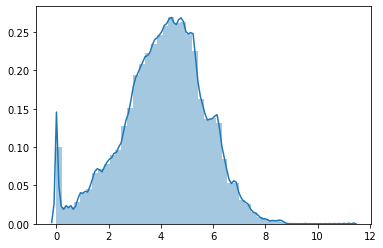

In [132]:
import lightgbm as lgb
target_meter = 0
X_train, y_train = create_X_y(train_meta, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

### Prediction on test data

In [135]:
test_df = pd.read_csv('test.csv')
weather_test_df = pd.read_csv('weather_test.csv')

In [139]:
print('preprocessing building...')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['date'] = test_df['timestamp'].dt.date
datetime_features(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
reduce_mem_usage(test_df)
reduce_mem_usage(weather_test_df)

gc.collect()


preprocessing building...
preprocessing weather...
reduce mem usage...
Mem. usage decreased to 1471.34 Mb (54.9% reduction)
Mem. usage decreased to 35.69 Mb (26.6% reduction)


0

In [152]:
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [141]:
test_df.head()

,row_id,building_id,meter,timestamp,date,hour,weekend,month,dayofweek,building_mean,building_median,building_min,building_max,building_std
0,0,0,0,2017-01-01,2017-01-01,0,6,1,6,5.433594,5.488281,0.0,5.804688,0.392578
1,1,1,0,2017-01-01,2017-01-01,0,6,1,6,4.761719,4.890625,0.0,5.390625,0.359619
2,2,2,0,2017-01-01,2017-01-01,0,6,1,6,2.998047,3.066406,0.0,4.234375,0.686523
3,3,3,0,2017-01-01,2017-01-01,0,6,1,6,5.875000,5.914062,0.0,6.488281,0.502441
4,4,4,0,2017-01-01,2017-01-01,0,6,1,6,7.343750,7.375000,0.0,7.570312,0.421875


In [161]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_metadata, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test
from tqdm import tqdm
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

  0%|          | 0/25 [00:00<?, ?it/s]

iterations 25
predicting 0-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 1-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 2-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 3-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 4-th model


100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


CPU times: user 39min 29s, sys: 1min 2s, total: 40min 32s
Wall time: 6min 52s


10

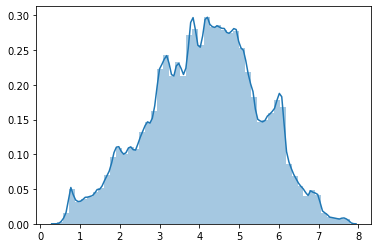

In [162]:
%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()
